In [186]:
from __future__ import division
import os
import requests
import re

from datetime import datetime, timedelta

from sklearn.cluster import KMeans

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
path = '/Users/ernestng/Desktop/projects/custseg/shopee.xlsx'

og_data = pd.read_excel(path, sheet_name = 'duplicate_title_sg')

In [3]:
og_data.head()

,itemid,shopid,item_name,item_description,item_variation,...,category,cb_option,is_preferred,sold_count,item_creation_date
0,1925574,210000,Golden mobile numbers,Unregistered prepaid cards1) 93355333 selling...,{},...,Mobile & Gadgets,0,0,0,2015-10-01 00:24:42
1,1925617,210000,Golden mobile numbers,Unregistered prepaid cards1) 93355888 selling...,{},...,Mobile & Gadgets,0,0,0,2015-10-01 00:26:37
2,943600,210000,Golden Mobile Numbers,Unregistered prepaid cards. Can port to post p...,{},...,Mobile & Gadgets,0,0,0,2015-08-25 21:02:13
3,1064405,210000,Golden Mobile Numbers,Unregistered prepaid cards. Can port to post p...,{},...,Mobile & Gadgets,0,0,0,2015-08-30 20:16:07
4,20046620,760000,101% AUTHENTIC BASEBALL CAPS,"PREORDER Takes about 23 weeks to arrive, will ...","{NEWERA BLACK: 35.0, NIKE SWOOSH DENIM: 35.0, ...",...,Women's Apparel,0,0,0,2016-05-09 01:14:34


In [4]:
og_data.columns

Index(['itemid', 'shopid', 'item_name', 'item_description', 'item_variation',
       'price', 'stock', 'category', 'cb_option', 'is_preferred', 'sold_count',
       'item_creation_date'],
      dtype='object')

# 1. Determining our Metrics to assess Shopee's growth in 2017

## Let's look at Revenue generated throughout 2017

In [5]:
data = og_data[og_data['item_creation_date'].dt.year == 2017]

data['item_creation_date'] = pd.to_datetime(data['item_creation_date'])

#creating YearMonth field for the ease of reporting and visualization
data['creationMth'] = data['item_creation_date'].map(lambda date: date.month)

#calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
data['Revenue'] = data['sold_count'] * data['price']
data_revenue = data.groupby(['creationMth'])['Revenue'].sum().reset_index()
data_revenue

,creationMth,Revenue
0,1,28064.30
1,2,32736.12
2,3,60154.28
3,4,55610.24
4,5,77845.38
5,6,229556.57
6,7,99284.68
7,8,93823.70
8,9,113178.12
9,10,42560.88


In [6]:
rev=list(data_revenue["Revenue"])
mth=list(data_revenue["creationMth"])

Text(0.5, 0, 'Month')

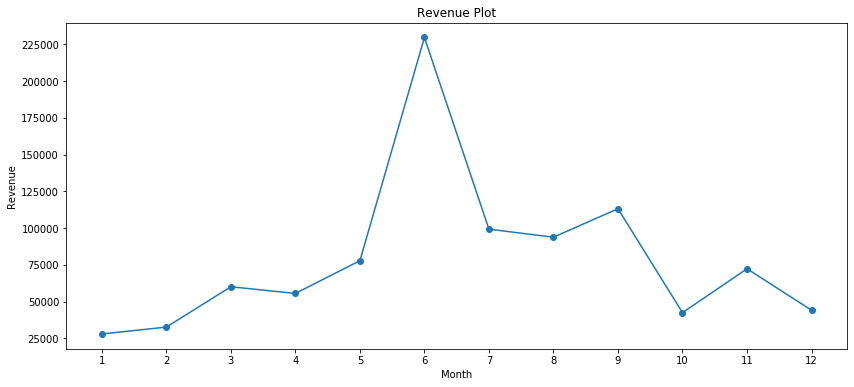

In [7]:
plt.scatter(x=np.array(mth),y=rev)
plt.plot(mth,rev)
plt.xticks(np.arange(min(mth), max(mth)+1, 1.0))
plt.title('Revenue Plot')
plt.ylabel('Revenue')
plt.xlabel('Month')

### Revenue shows increasing trend from Jan to Jun before showing a decreasing trend from Jun to Dec

## From here, I will calculate the percentage change in Revenue from month to month to look at the Revenue Growth throughout 2017

In [8]:
data_revenue['MonthlyGrowth'] = data_revenue['Revenue'].pct_change()
data_revenue.head(8)

,creationMth,Revenue,MonthlyGrowth
0,1,28064.30,NaN
1,2,32736.12,0.166468
2,3,60154.28,0.837551
3,4,55610.24,-0.075540
4,5,77845.38,0.399839
5,6,229556.57,1.948879
6,7,99284.68,-0.567494
7,8,93823.70,-0.055003


Text(0.5, 0, 'Month')

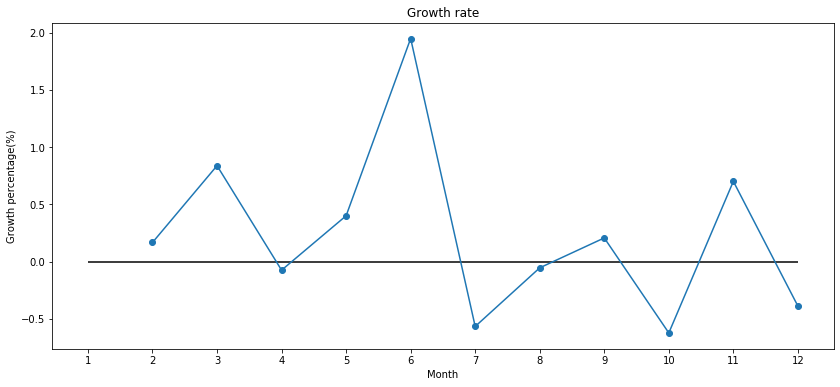

In [9]:
plt.scatter(x=data_revenue['creationMth'],y=data_revenue['MonthlyGrowth'])
plt.plot(data_revenue['creationMth'],data_revenue['MonthlyGrowth'])
plt.hlines(y=0,xmin=1,xmax=12)
plt.xticks(np.arange(min(mth), max(mth)+1, 1.0))
plt.title('Growth rate')
plt.ylabel('Growth percentage(%)')
plt.xlabel('Month')

### Growth rate dropped the most from Jun to Jul. So what happened in Jul? Were the shops less active or were there less customers buying?

## I want to see if the number of Active Shops per month would affect growth

### I define a shop to be active in a month if they have posted a product in that time frame

In [10]:
#creating monthly active shops dataframe by counting unique shop IDs
mthly_active = data.groupby('creationMth')['shopid'].nunique().reset_index()

#print the dataframe
mthly_active

,creationMth,shopid
0,1,386
1,2,440
2,3,568
3,4,589
4,5,582
5,6,604
6,7,712
7,8,745
8,9,845
9,10,847


Text(0.5, 0, 'Month')

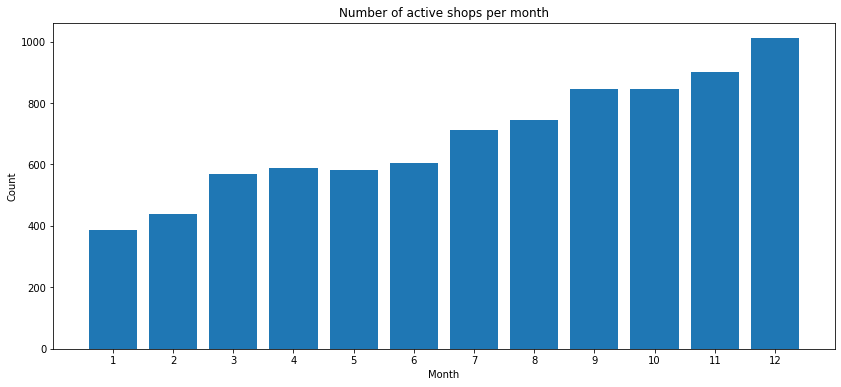

In [11]:
plt.bar(x=mthly_active['creationMth'],height=mthly_active['shopid'])
plt.xticks(np.arange(min(mth), max(mth)+1, 1.0))
plt.title('Number of active shops per month')
plt.ylabel('Count')
plt.xlabel('Month')

### We observe there was actually a slight increase in number of active shops from 712 in Jun to 745 in Jul.

# Now I am curious to see how many products are sold in each month and if it has any impact on growth rate.

### I expect to see an increase in products sold from Jun to Jul since there is an increase in number of active shops

In [12]:
mthly_sales = data.groupby('creationMth')['sold_count'].sum().reset_index()

#print the dataframe
mthly_sales

,creationMth,sold_count
0,1,3175
1,2,5784
2,3,5312
3,4,6850
4,5,7620
5,6,5625
6,7,7759
7,8,11551
8,9,9423
9,10,5667


Text(0.5, 0, 'Month')

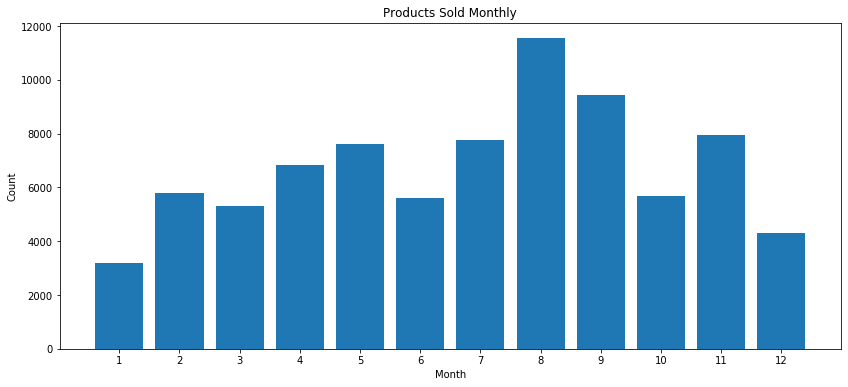

In [13]:
plt.bar(x=mthly_sales['creationMth'],height=mthly_sales['sold_count'])
plt.xticks(np.arange(min(mth), max(mth)+1, 1.0))
plt.title('Products Sold Monthly')
plt.ylabel('Count')
plt.xlabel('Month')

### Sold count increases as expected in Jul (5625 in Jun to 7759 in Jul, 37.9% increase) since number of active shops increased in Jul. We know that number of active shops per month directly affects products sold per month. Hence, we should definitely check our Average Revenue per Order as well.

## It would make sense to calculate the Average Revenue per Product since I have observed a dip in revenue although there is an increase in products sold

In [14]:
mthly_order_avg = data.groupby('creationMth')['Revenue'].mean().reset_index()

#print the dataframe
mthly_order_avg

,creationMth,Revenue
0,1,7.797805
1,2,4.120861
2,3,5.249523
3,4,4.002464
4,5,4.823433
5,6,14.838822
6,7,8.054245
7,8,5.250641
8,9,4.824919
9,10,1.844858


Text(0.5, 0, 'Month')

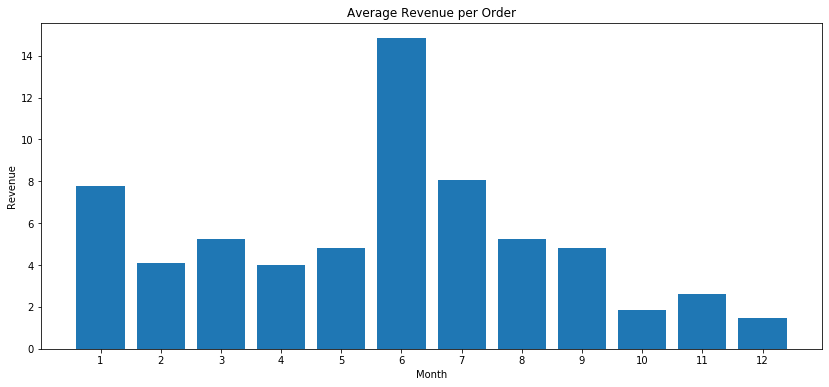

In [15]:
plt.bar(x=mthly_order_avg['creationMth'],height=mthly_order_avg['Revenue'])
plt.xticks(np.arange(min(mth), max(mth)+1, 1.0))
plt.title('Average Revenue per Order')
plt.ylabel('Revenue')
plt.xlabel('Month')

### The average revenue per order average dropped for Jul (14.8 in Jun to 8.05 in Jul, 45.6% decrease).

### While more products are being sold in Jul, the revenue generated from each order is lesser compared to other months. This could explain the drop in revenue for Jul.

# Comparing New and Existing Shops

### For an ecommerce platform like Shopee, there will always be new shops/sellers entering the platform and existing ones that are popular among users. 

### Hence I would want to compare the revenue generated by both groups and see if I can identify the reason behind the drop in revenue in Jun.

In [16]:
data.reset_index()

,index,itemid,shopid,item_name,item_description,...,is_preferred,sold_count,item_creation_date,creationMth,Revenue
0,7,252736983,11272000,Hada Labo Super Hydrating Perfect Gel Moisturi...,Hada Labo is a skin care line researched & dev...,...,1,1,2017-05-09 18:33:30,5,28.72
1,8,793229430,49082000,Women Lace Bra Bustier Crop Tops Soft Mesh Tri...,Material: Terylene Colors: BalckStyle: Sexy Br...,...,0,0,2017-12-28 19:55:45,12,0.00
2,13,793240796,49082000,Women Floral Lace Sexy Comfortable Low Rise No...,"Material: LycraColor: Black, WhiteStyle: Sexy ...",...,0,0,2017-12-28 20:00:28,12,0.00
3,55,774078057,28682001,2017 mens Martin boots high to help casual shoes,Source categories: spotItem: H31Upper material...,...,0,0,2017-12-20 22:12:55,12,0.00
4,56,774078059,28682001,2017 mens Martin boots high to help casual shoes,Source categories: spotBrand: Hao RoadItem: H0...,...,0,0,2017-12-20 22:12:55,12,0.00
...,...,...,...,...,...,...,...,...,...,...,...
202454,464428,517929442,13744999,Women Back Brest Dress Package Hips Dress,Type: Dress Gender: Womens Size Type: Regular ...,...,0,0,2017-09-24 18:42:46,9,0.00
202455,464429,490461243,13744999,Heart Alloy Pendant Necklace for women,Gender: For Women Item Type: Pendant Necklaces...,...,0,0,2017-09-15 21:10:15,9,0.00
202456,464430,494272761,13744999,Heart Alloy Pendant Necklace for women,Gender: For Women Item Type: Pendant Necklaces...,...,0,0,2017-09-17 09:07:06,9,0.00
202457,464431,259494170,13744999,Women Mid Elastic Waist Straight Shorts,"Style: Active Length: Mini Material: Nylon,Pol...",...,0,1,2017-05-14 11:46:53,5,2.00


In [17]:
#create a dataframe contaning shopid and first item creation date
min_purchase = data.groupby('shopid').item_creation_date.min().reset_index()
min_purchase.columns = ['shopid','MinCreationDates']
min_purchase['MinCreationMth'] = min_purchase['MinCreationDates'].map(lambda date: date.month)

#merge first item creation month column to our main dataframe (data)
data = pd.merge(data, min_purchase, on='shopid')

data.head()

,itemid,shopid,item_name,item_description,item_variation,...,item_creation_date,creationMth,Revenue,MinCreationDates,MinCreationMth
0,252736983,11272000,Hada Labo Super Hydrating Perfect Gel Moisturi...,Hada Labo is a skin care line researched & dev...,{},...,2017-05-09 18:33:30,5,28.72,2017-05-09 18:33:30,5
1,793229430,49082000,Women Lace Bra Bustier Crop Tops Soft Mesh Tri...,Material: Terylene Colors: BalckStyle: Sexy Br...,"{S: 9.98, M: 9.98, L: 9.98, XL: 9.98}",...,2017-12-28 19:55:45,12,0.00,2017-12-28 19:55:45,12
2,793240796,49082000,Women Floral Lace Sexy Comfortable Low Rise No...,"Material: LycraColor: Black, WhiteStyle: Sexy ...","{Black-XL: 7.69, White-S: 7.69, Black-S: 7.69,...",...,2017-12-28 20:00:28,12,0.00,2017-12-28 19:55:45,12
3,774078057,28682001,2017 mens Martin boots high to help casual shoes,Source categories: spotItem: H31Upper material...,"{White -39: 13.98, White -44: 13.98, White -43...",...,2017-12-20 22:12:55,12,0.00,2017-11-28 10:39:57,11
4,774078059,28682001,2017 mens Martin boots high to help casual shoes,Source categories: spotBrand: Hao RoadItem: H0...,"{Green -41: 15.6, Black -40: 15.6, Green -43: ...",...,2017-12-20 22:12:55,12,0.00,2017-11-28 10:39:57,11


In [18]:
#create a column called Shop Type and assign Existing 
#if Shop's First Purchase Month before the selected Invoice Year Month
data['UserType'] = 'New'
data.loc[data['creationMth']>data['MinCreationMth'],'UserType'] = 'Existing'

#calculate the Revenue per month for each user type
shop_type_revenue = data.groupby(['creationMth','UserType'])['Revenue'].sum().reset_index()
shop_type_revenue

,creationMth,UserType,Revenue
0,1,New,28064.30
1,2,Existing,10110.15
2,2,New,22625.97
3,3,Existing,19448.57
4,3,New,40705.71
5,4,Existing,22337.26
6,4,New,33272.98
7,5,Existing,38560.55
8,5,New,39284.83
9,6,Existing,202215.42


## Comparing revenue generated from New and Existing Shops

In [19]:
new_shop = shop_type_revenue[shop_type_revenue['UserType']=='New'].reset_index()
existing_shop = shop_type_revenue[shop_type_revenue['UserType']=='Existing'].reset_index()
new_shop.head()

,index,creationMth,UserType,Revenue
0,0,1,New,28064.30
1,2,2,New,22625.97
2,4,3,New,40705.71
3,6,4,New,33272.98
4,8,5,New,39284.83


Text(0.5, 0, 'Month')

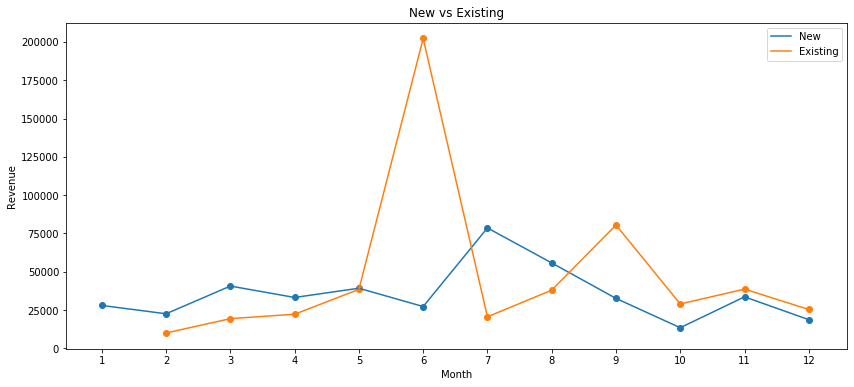

In [20]:
plt.scatter(x=new_shop['creationMth'],y=new_shop['Revenue'])
plt.plot(new_shop['creationMth'],new_shop['Revenue'],label='New')
plt.scatter(x=existing_shop['creationMth'],y=existing_shop['Revenue'])
plt.plot(existing_shop['creationMth'],existing_shop['Revenue'],label='Existing')
plt.xticks(np.arange(min(mth), max(mth)+1, 1.0))
plt.legend()
plt.title('New vs Existing')
plt.ylabel('Revenue')
plt.xlabel('Month')

### In Jun, there is a much higher number of existing shops and they brought in more than 200k worth of revenue. However in Jul, revenue from existing shops dropped to less than 25k and is lesser than what was brought in by new shops. This could reflect a drop in growth rate for that month since existing shops are those that bring in more revenue. 

## New Shop Ratio

In [21]:
user_ratio = data.query("UserType == 'New'").groupby(['creationMth'])['shopid'].nunique()/data.query("UserType == 'Existing'").groupby(['creationMth'])['shopid'].nunique() 
user_ratio = user_ratio.reset_index()
user_ratio = user_ratio.dropna()
user_ratio

,creationMth,shopid
1,2,2.492063
2,3,1.318367
3,4,1.181481
4,5,0.972881
5,6,0.875776
6,7,1.011299
7,8,0.740654
8,9,0.745868
9,10,0.664047
10,11,0.603203


Text(0.5, 0, 'Month')

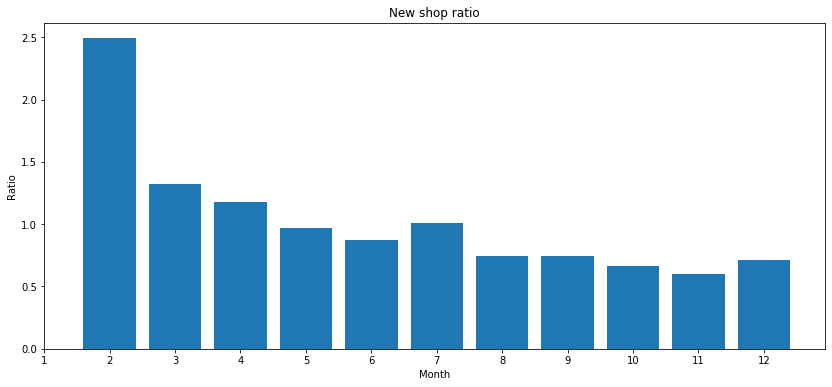

In [22]:
plt.bar(x=user_ratio['creationMth'],height=user_ratio['shopid'])
plt.xticks(np.arange(min(mth), max(mth)+1, 1.0))
plt.title('New shop ratio')
plt.ylabel('Ratio')
plt.xlabel('Month')

### This plot shows a decreasing trend in new shops ratio which could imply the inability to attract new shops or perhaps losing shops.

# Monthly Retention Rate

## The retention rate shows us which shops were active on which months and if they were still active the next month. This is an indication of how sticky the service is and how well the ecommerce platform's marketing tactics fits the shops' interest

### Monthly Retention Rate = Retained Shops From Prev. Month / Active Shops Total

In [23]:
#identify which shops are active by looking at their revenue per month
shop_purchase = data.groupby(['shopid','creationMth'])['Revenue'].sum().reset_index()

#create retention matrix with crosstab
shop_retention = pd.crosstab(shop_purchase['shopid'], shop_purchase['creationMth']).reset_index()

shop_retention.head()

creationMth,shopid,1,2,3,4,...,8,9,10,11,12
0,10009,0,0,1,0,...,0,0,0,0,0
1,10021,0,1,0,0,...,0,0,0,1,0
2,10042,0,0,0,0,...,0,0,0,0,0
3,10058,1,0,1,0,...,0,0,0,0,0
4,10102,0,0,0,0,...,0,0,0,1,0


In [24]:
#create an array of dictionary which keeps Retained & Total Shops count for each month
months = shop_retention.columns[1:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['creationMth'] = int(selected_month)
    retention_data['TotalShopCount'] = shop_retention[selected_month].sum()
    retention_data['RetainedShopCount'] = shop_retention[(shop_retention[selected_month]>0) & (shop_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
shop_retention = pd.DataFrame(retention_array)
shop_retention['RetentionRate'] = shop_retention['RetainedShopCount']/shop_retention['TotalShopCount']

In [25]:
shop_retention.head()

,creationMth,TotalShopCount,RetainedShopCount,RetentionRate
0,2,440,126,0.286364
1,3,568,199,0.350352
2,4,589,231,0.392190
3,5,582,217,0.372852
4,6,604,220,0.364238


Text(0.5, 0, 'Month')

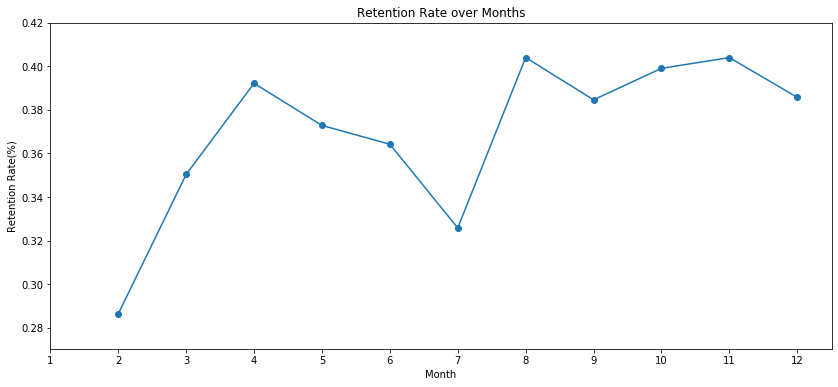

In [26]:
plt.scatter(x=shop_retention['creationMth'],y=shop_retention['RetentionRate'])
plt.plot(shop_retention['creationMth'],shop_retention['RetentionRate'])
plt.xticks(np.arange(min(mth), max(mth)+1, 1.0))
plt.title('Retention Rate over Months')
plt.ylabel('Retention Rate(%)')
plt.xlabel('Month')

### From May to Jul, we see a decrease in retention rate, implying that existing shops from those months were not active in the following month. Retention rate can be seen at its lowest point in Jul. We do not include that Feb since we do not data on Jan.

# Cohort Based Retention Rate

## Cohorts are determined as first item creation year-month of the shops. I will be measuring what percentage of the shops retained after their first item creation in each month. This view will help us to see how recent and old cohorts differ regarding retention rate and if recent changes in shop experience affects a new shop’s retention or not.

In [27]:
#create our retention table again with crosstab() - we need to change the column names for using them in .query() function
coh_retention = pd.crosstab(shop_purchase['shopid'], shop_purchase['creationMth']).reset_index()
new_column_names = [ 'm_' + str(column) for column in coh_retention.columns]
coh_retention.columns = new_column_names

#create the array of Retained shops for each cohort monthly
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count =  retention_data['TotalShopCount'] = coh_retention['m_' + str(selected_month)].sum()
    retention_data[selected_month] = 1 
    
    query = "{} > 0".format('m_' + str(selected_month))
    

    for next_month in next_months:
        query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(coh_retention.query(query)['m_' + str(next_month)].sum()/total_user_count,2)
    retention_array.append(retention_data)
    
coh_retention = pd.DataFrame(retention_array)
coh_retention.index = months

#showing new cohort based retention table
coh_retention

,TotalShopCount,1,2,3,4,...,8,9,10,11,12
creationMth,,,,,,,,,,,
1,386,1.0,0.33,0.21,0.13,...,0.03,0.02,0.02,0.02,0.02
2,440,NaN,1.00,0.45,0.25,...,0.05,0.04,0.04,0.03,0.03
3,568,NaN,NaN,1.00,0.41,...,0.07,0.06,0.05,0.04,0.03
4,589,NaN,NaN,NaN,1.00,...,0.10,0.07,0.06,0.04,0.03
5,582,NaN,NaN,NaN,NaN,...,0.14,0.10,0.08,0.06,0.04
6,604,NaN,NaN,NaN,NaN,...,0.21,0.15,0.11,0.08,0.06
7,712,NaN,NaN,NaN,NaN,...,0.42,0.23,0.15,0.10,0.07
8,745,NaN,NaN,NaN,NaN,...,1.00,0.44,0.24,0.15,0.10
9,845,NaN,NaN,NaN,NaN,...,NaN,1.00,0.40,0.22,0.14


### From the cohort based retention table, of all shops that join Shopee in Jan 2017, only 0.02% retain after a year.

# 2. Customer Segmentation

### Each customer has to be treated differently if we want to increase retention rate. By doing customer segmentation, I sort the customers into different categories and different marketing methods can be implemented for the respective segments.
### RFM stands for Recency - Frequency - Monetary Value. I will use the RFM CLUSTERING METHOD in this case to determine low, medium and high value customers.
#### Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.
#### Mid Value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.
#### High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

## Recency Cluster
### We want to see how many days has it been since each shop last posted an item comparative to other shops

In [236]:
#create a generic shop dataframe to keep shopid and new segmentation scores
shop = pd.DataFrame(data['shopid'].unique())
shop.columns = ['shopid']

#get the max item creation date for each shop and create a dataframe with it
shop_max_purchase = data.groupby('shopid')['item_creation_date'].max().reset_index()
shop_max_purchase.columns = ['shopid','MaxPurchaseDate']

#we take our observation point as the max item creation date in our dataset
shop_max_purchase['Recency'] = (shop_max_purchase['MaxPurchaseDate'].max() - shop_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new shop dataframe
shop = pd.merge(shop, shop_max_purchase[['shopid','Recency']], on='shopid')

shop.head()

,shopid,Recency
0,11272000,236
1,49082000,3
2,28682001,11
3,26451002,115
4,33544002,95


In [237]:
shop.Recency.describe()

count    4044.000000
mean      126.076657
std       106.165578
min         0.000000
25%        30.750000
50%        99.000000
75%       209.000000
max       364.000000
Name: Recency, dtype: float64

#### Average inactivity for a shop is 126 days and median is 99, with the highest being 364 days
#### We can see the distribution of recency in the histogram plot below

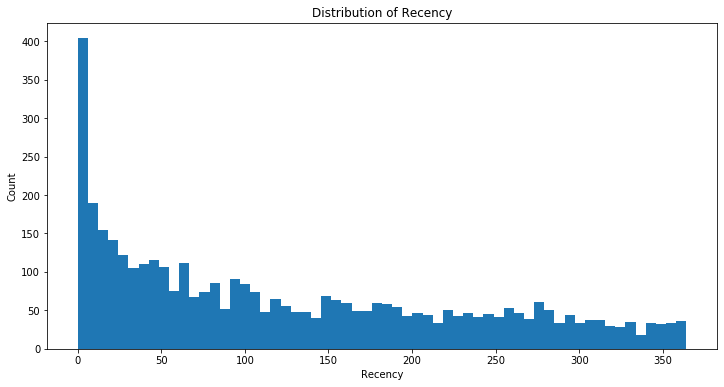

In [238]:
plt.hist(shop['Recency'], bins=60)
plt.title('Distribution of Recency')
plt.ylabel('Count')
plt.xlabel('Recency');

### I am going to apply K-means clustering to assign a recency score. But I need to tell how many clusters are needed for the K-means algorithm. To find it out, I will apply Elbow Method, which simply gives the optimal cluster number for optimal inertia. 

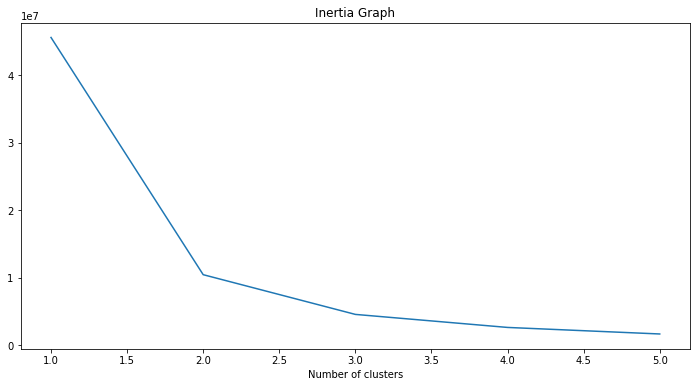

In [239]:
sse={}
recency = shop[['Recency']]
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Inertia Graph")
plt.xlabel("Number of clusters")
plt.show()

#### 3 seems to be the optimal number of clusters

### I will build 3 clusters for recency - Cluster 0, 1, 2

#### I write another function order_cluster to return them in a way I can say that Cluster 0 is the worst and Cluster 2 is the best

In [240]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(shop[['Recency']])
shop['RecencyCluster'] = kmeans.predict(shop[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    #new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

shop = order_cluster('RecencyCluster', 'Recency',shop,False)

In [241]:
shop.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,968.0,283.435950,41.896509,216.0,248.0,279.0,316.0,364.0
1,1165.0,147.745064,36.297232,91.0,115.0,148.0,179.0,215.0
2,1911.0,33.158032,26.312124,0.0,10.0,27.0,53.5,90.0


#### Cluster 2 contains the active shops while Cluster 0 contains the inactive ones.

## Frequency cluster
### To create frequency clusters, I want to find total number of items each shop has to offer.

In [242]:
freq_shop = data.groupby('shopid')['itemid'].nunique().reset_index()
freq_shop.columns = ['shopid','Frequency']

#add this data to our main dataframe
shop = pd.merge(shop, freq_shop, on='shopid')

In [245]:
shop.head()

,shopid,Recency,RecencyCluster,Frequency
0,11272000,236,0,1
1,4679003,304,0,7
2,5904004,262,0,6
3,1328004,278,0,4
4,8592006,311,0,2


In [246]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(shop[['Frequency']])
shop['FrequencyCluster'] = kmeans.predict(shop[['Frequency']])

shop = order_cluster('FrequencyCluster', 'Frequency',shop,True)

In [247]:
#plt.hist(shop['Frequency'], bins=60)
#plt.title('Distribution of Frequency')
#plt.ylabel('Count')
#plt.xlabel('Frequency');

In [250]:
shop.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3845.0,21.173212,40.586109,1.0,2.0,4.0,17.00,247.0
1,186.0,478.559140,223.741282,254.0,316.0,413.5,554.25,1324.0
2,13.0,2464.307692,1210.237193,1637.0,1794.0,1905.0,2597.00,5983.0


#### Cluster 2 contains shops who sell more items. On the other hand, Cluster 0 contains those that sell the least. Generally, shops in Cluster 2 are shops that we want to keep

## Revenue cluster

### Here, I calculate revenue generated by each shop, plot a histogram and apply the same clustering method.

In [251]:
#calculate revenue for each shop
shop_revenue = data.groupby('shopid')['Revenue'].sum().reset_index()

#merge it with our main dataframe
shop = pd.merge(shop, shop_revenue, on='shopid')

In [252]:
shop.head()

,shopid,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,11272000,236,0,1,0,28.72
1,4679003,304,0,7,0,0.00
2,5904004,262,0,6,0,61.00
3,1328004,278,0,4,0,0.00
4,8592006,311,0,2,0,0.00


In [253]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(shop[['Revenue']])
shop['RevenueCluster'] = kmeans.predict(shop[['Revenue']])

shop = order_cluster('RevenueCluster', 'Revenue',shop,True)

In [254]:
shop.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,4039.0,154.43689,674.175176,0.00,0.000,0.00,51.500,14472.00
1,4.0,36937.51000,18392.939502,19970.30,25281.425,32911.90,44567.985,61955.94
2,1.0,177891.88000,NaN,177891.88,177891.880,177891.88,177891.880,177891.88


#### Cluster 2 only has 1 shop which brings a huge amount of revenue. Cluster 0 has many shops the mean revenue can be shown to be low

## Overall Score for each shop
### I add up all 3 cluster numbers for each shop to get their overall score

In [255]:
shop['OverallScore'] = shop['RecencyCluster'] + shop['FrequencyCluster'] + shop['RevenueCluster']
shop.groupby('OverallScore')[['Recency','Frequency','Revenue']].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,283.855042,10.623950,69.210179
1,149.404049,19.030810,115.901972
2,36.389165,42.500276,212.318668
3,27.905109,518.722628,880.993577
4,25.000000,2277.800000,24707.920000


#### The scoring above clearly shows us that customers with score 5 is our best shops whereas 0 is the worst. To simplify things, I will name these scores:
#### 0 - 1 : Low Value
#### 2 - 3 : Mid Value
#### 4       : High Value

In [256]:
shop['Value'] = 'Low'
shop.loc[shop['OverallScore']>1,'Value'] = 'Mid' 
shop.loc[shop['OverallScore']>3,'Value'] = 'High' 

In [263]:
shop

,shopid,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Value
0,11272000,236,0,1,0,28.72,0,0,Low
1,4679003,304,0,7,0,0.00,0,0,Low
2,5904004,262,0,6,0,61.00,0,0,Low
3,1328004,278,0,4,0,0.00,0,0,Low
4,8592006,311,0,2,0,0.00,0,0,Low
...,...,...,...,...,...,...,...,...,...
4039,21108609,242,0,2,0,19970.30,1,1,Low
4040,13132381,170,1,2,0,27051.80,1,2,Mid
4041,30628794,140,1,1,0,38772.00,1,2,Mid
4042,30769353,4,2,653,1,61955.94,1,4,High


In [258]:
shop.groupby('Value')[['Recency','Frequency','Revenue']].mean()

,Recency,Frequency,Revenue
Value,,,
High,25.000000,2277.800000,24707.920000
Low,210.705460,15.197797,94.613376
Mid,35.791881,76.026721,259.393931


In [265]:
data.head()

,itemid,shopid,item_name,item_description,item_variation,...,creationMth,Revenue,MinCreationDates,MinCreationMth,UserType
0,252736983,11272000,Hada Labo Super Hydrating Perfect Gel Moisturi...,Hada Labo is a skin care line researched & dev...,{},...,5,28.72,2017-05-09 18:33:30,5,New
1,793229430,49082000,Women Lace Bra Bustier Crop Tops Soft Mesh Tri...,Material: Terylene Colors: BalckStyle: Sexy Br...,"{S: 9.98, M: 9.98, L: 9.98, XL: 9.98}",...,12,0.00,2017-12-28 19:55:45,12,New
2,793240796,49082000,Women Floral Lace Sexy Comfortable Low Rise No...,"Material: LycraColor: Black, WhiteStyle: Sexy ...","{Black-XL: 7.69, White-S: 7.69, Black-S: 7.69,...",...,12,0.00,2017-12-28 19:55:45,12,New
3,774078057,28682001,2017 mens Martin boots high to help casual shoes,Source categories: spotItem: H31Upper material...,"{White -39: 13.98, White -44: 13.98, White -43...",...,12,0.00,2017-11-28 10:39:57,11,Existing
4,774078059,28682001,2017 mens Martin boots high to help casual shoes,Source categories: spotBrand: Hao RoadItem: H0...,"{Green -41: 15.6, Black -40: 15.6, Green -43: ...",...,12,0.00,2017-11-28 10:39:57,11,Existing
